# Calibración de clasificadores

## Importación de librerias y creación de funciones

In [3]:
# Importar las bibliotecas necesarias
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_score,f1_score,log_loss,brier_score_loss
from betacal import BetaCalibration
import joblib


In [4]:
def load_csv(ruta_csv):
    try:
        df = pd.read_csv(ruta_csv)
        return df
    except FileNotFoundError:
        print(f"El archivo en la ruta {ruta_csv} no se encontró.")
    except pd.errors.EmptyDataError:
        print("El archivo CSV está vacío.")
    except pd.errors.ParserError:
        print("Error al analizar el archivo CSV.")
    except Exception as e:
        print(f"Ocurrió un error: {e}")

In [5]:
def load_pkl(ruta):
    
    with open(ruta, 'rb') as archivo:
        datos = pickle.load(archivo)
    return datos

In [6]:
def load_validation_data(ruta_csv):
    df=load_csv(ruta_csv)
    independent_var_erase=[''] # Eliminamos la variable de precipitacion acumulada a los 10 dias
    dependent_var='deslizamientos'
    independent_var=[x for x in df.columns if x not in independent_var_erase and x not in dependent_var]
    X=df[independent_var]
    y=df[dependent_var]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.5, test_size=0.5,random_state=23)
    return X_valid, y_valid

In [7]:
def load_models(ruta_m):
    ruta_modelos=ruta_m
    modelos=[archivo for archivo in os.listdir(ruta_modelos) if os.path.isfile(os.path.join(ruta_modelos, archivo))]

    dict_modelos={}
    for modelo in modelos:
        pkl=load_pkl(os.path.join(ruta_modelos,modelo))
        key=modelo.split('.')[0]
        dict_modelos[key]=pkl

    rf=dict_modelos['random-forest-model']
    xgb=dict_modelos['xgboosted-trees-model']
    lr=dict_modelos['logistic-regressor-model']
    svc=dict_modelos['svc-model']

    return rf,xgb,lr,svc

In [8]:
def preprocess_data(encoder,df):
    columns_to_encode=list(encoder.keys())
    df2=df.copy()
    for column in columns_to_encode:
        array=encoder[column].transform(df2[column])
        df2[column]=array
    
    return df2

In [9]:
def validation_model_performance(ruta_m,ruta_csv):
    rf,xgb,lr,svc=load_models(ruta_m)
    X_valid, y_valid=load_validation_data(ruta_csv)

    # RF
    model_rf=rf['modelo']
    encoder_rf=rf['encoder']

    X_valid_rf=preprocess_data(encoder_rf,X_valid)
    X_valid_rf=X_valid_rf.drop(columns=['10d'])

    y_pred_rf = model_rf.predict(X_valid_rf)
    precision_rf = precision_score(y_valid, y_pred_rf)
    accuracy_rf = accuracy_score(y_valid, y_pred_rf)
    recall_rf = recall_score(y_valid, y_pred_rf)
    f1_rf = f1_score(y_valid, y_pred_rf)

    # XGBoost
    model_xgb=xgb['modelo']
    encoder_xgb=xgb['encoder']

    X_valid_xgb=preprocess_data(encoder_xgb,X_valid)
    X_valid_xgb=X_valid_xgb.drop(columns=['10d'])

    y_pred_xgb = model_xgb.predict(X_valid_xgb)
    precision_xgb = precision_score(y_valid, y_pred_xgb)
    accuracy_xgb = accuracy_score(y_valid, y_pred_xgb)
    recall_xgb = recall_score(y_valid, y_pred_xgb)
    f1_xgb = f1_score(y_valid, y_pred_xgb)

    # Logistic Reg
    model_lr=lr['modelo']
    encoder_lr=lr['encoder']

    X_valid_lr=preprocess_data(encoder_lr,X_valid)
    X_valid_lr=X_valid_lr.drop(columns=['7d','15d','60d'])

    y_pred_lr = model_lr.predict(X_valid_lr)
    precision_lr = precision_score(y_valid, y_pred_lr)
    accuracy_lr = accuracy_score(y_valid, y_pred_lr)
    recall_lr = recall_score(y_valid, y_pred_lr)
    f1_lr = f1_score(y_valid, y_pred_lr)

    # SVC
    model_svc=svc['modelo']
    encoder_svc=svc['encoder']

    X_valid_svc=preprocess_data(encoder_svc,X_valid)
    X_valid_svc=X_valid_svc.drop(columns=['10d'])

    y_pred_svc = model_svc.predict(X_valid_svc)
    precision_svc = precision_score(y_valid, y_pred_svc)
    accuracy_svc = accuracy_score(y_valid, y_pred_svc)
    recall_svc = recall_score(y_valid, y_pred_svc)
    f1_svc = f1_score(y_valid, y_pred_svc)

    #####
    data_reporte = {
        'Modelo': ['Random Forest Classifier','Gradient Boosting Classifier','Logistic Regressor','Support Vector Classifer'
                   ],
        'Precision': [precision_rf,precision_xgb,precision_lr,precision_svc
                      ],
        'Recall': [recall_rf,recall_xgb,accuracy_lr,accuracy_svc
                   ],
        'Exactitud': [accuracy_rf,accuracy_xgb,recall_lr,recall_svc
                      ],
        'F1-score': [f1_rf,f1_xgb,f1_lr,f1_svc
                     ]
    }

    df_reporte = pd.DataFrame(data_reporte)
    return df_reporte

In [10]:
# Función para calcular el Expected Calibration Error (ECE)
# def calculate_ece(y_true, y_prob, fraction_of_positives,mean_predicted_value,n_bins=7):
#     bin_sizes = np.histogram(y_prob, bins=n_bins)[0]
#     total_samples = len(y_true)
    
#     ece = np.sum((bin_sizes / total_samples) * np.abs(mean_predicted_value - fraction_of_positives))
#     return ece
# n_bins=10
# def calculate_ece(y_true, y_prob, n_bins=n_bins):
#     # Calcular la curva de calibración
#     fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob, n_bins=n_bins)
#     # Calcular el tamaño de cada bin
#     bin_counts, bin_edges = np.histogram(y_prob, bins=n_bins)
#     total_samples = len(y_true)
    
#     # Ajustar la longitud de `fraction_of_positives` y `mean_predicted_value` para incluir bins vacíos
#     extended_fraction_of_positives = np.zeros(n_bins)
#     extended_mean_predicted_value = np.zeros(n_bins)
    
#     bin_index = 0  # índice para fracciones no vacías
#     for i in range(n_bins):
#         if bin_counts[i] > 0 and bin_index < len(fraction_of_positives):
#             extended_fraction_of_positives[i] = fraction_of_positives[bin_index]
#             extended_mean_predicted_value[i] = mean_predicted_value[bin_index]
#             bin_index += 1
#         else:
#             extended_fraction_of_positives[i] = 0  # o NaN si prefieres indicar un bin vacío
    
#     # Calcular ECE considerando todos los bins, incluyendo los vacíos
#     ece = np.sum((bin_counts / total_samples) * np.abs(extended_mean_predicted_value - extended_fraction_of_positives))
#     return ece


n_bins=8
def calculate_ece(y_true_labels, y_prob, fraction_of_positives, mean_predicted_value, n_bins=n_bins):

    # Validar tamaños de entrada
    assert len(fraction_of_positives) == n_bins, "fraction_of_positives debe coincidir con n_bins."
    assert len(mean_predicted_value) == n_bins, "mean_predicted_value debe coincidir con n_bins."

    # Calcular ECE: promedio ponderado de |mean_predicted_value - fraction_of_positives|
    bin_counts = np.histogram(y_prob, bins=n_bins, range=(0, 1))[0]
    total_samples = len(y_true_labels)
    
    ece = np.sum(bin_counts / total_samples * np.abs(mean_predicted_value - fraction_of_positives))
    
    return ece

## Revisión de Modelos

Recapitulando, se muestra el comportamiento de los mejores modelos selectos durante el proceso de validación cruzada, en la siguiente tabla se proyectan sus rendimientos en la etapa de entrenamiento y de prueba.

| Modelo | Rendimiento en Train (Precision) | Rendimiento en Test (Precision) |
| --------- | --------- | --------- |
| Random Forest Classifier    | 0.9990    | 0.9045    |
| Gradient Boosting Classifier    | 1.0    | 0.9522  |
| Logistic Regressor    | 0.9190    | 0.9018   |
| Support Vector Classifer    | 0.9505    | 0.9366    |

Como podemos observar, todos los modelos usados se ajustan bastante bien a la data de entrenamiento. En estos casos se puede tomar la decisión del mejor modelo a usar dependiendo de otros aspectos, por ejemplo, el tiempo de entrenamiento, el recurso computacional consumido, la versatilidad del modelo y que tan calibrado está, esto último lo revisaremos con detalle más adelante.


Veamos ahora como les fue con data de validación, la cual nunca habían visto durante el entrenamiento y prueba:

In [11]:
df_reporte=validation_model_performance(os.path.join('..','Models','output'),os.path.join('..','Data','output','train_data_1.csv'))
df_reporte

,Modelo,Precision,Recall,Exactitud,F1-score
0,Random Forest Classifier,0.926740,0.944030,0.926316,0.935305
1,Gradient Boosting Classifier,0.973384,0.955224,0.960000,0.964218
2,Logistic Regressor,0.929688,0.898947,0.888060,0.908397
3,Support Vector Classifer,0.935484,0.890526,0.865672,0.899225


En la función anterior, evaluamos cada modelo con data de validación, vemos en la tabla todos los modelos tuvieron buenos puntajes con data que nunca habían visto, lo que nos da indicios de que se ajusta bien a nuestra data de entrenamiento y son bueno para clasificar. 


Ahora debemos validar si están bien calibrados o no. 

## Validación de calibración para los clasificadores

Como ya se habia explicado anteriormente, usaremos los 3 metodos explicados en la sección de [Calibradores de probabilidad](intro.md#calibradores-de-probabilidad), empezaremos analizando la curva de calibración

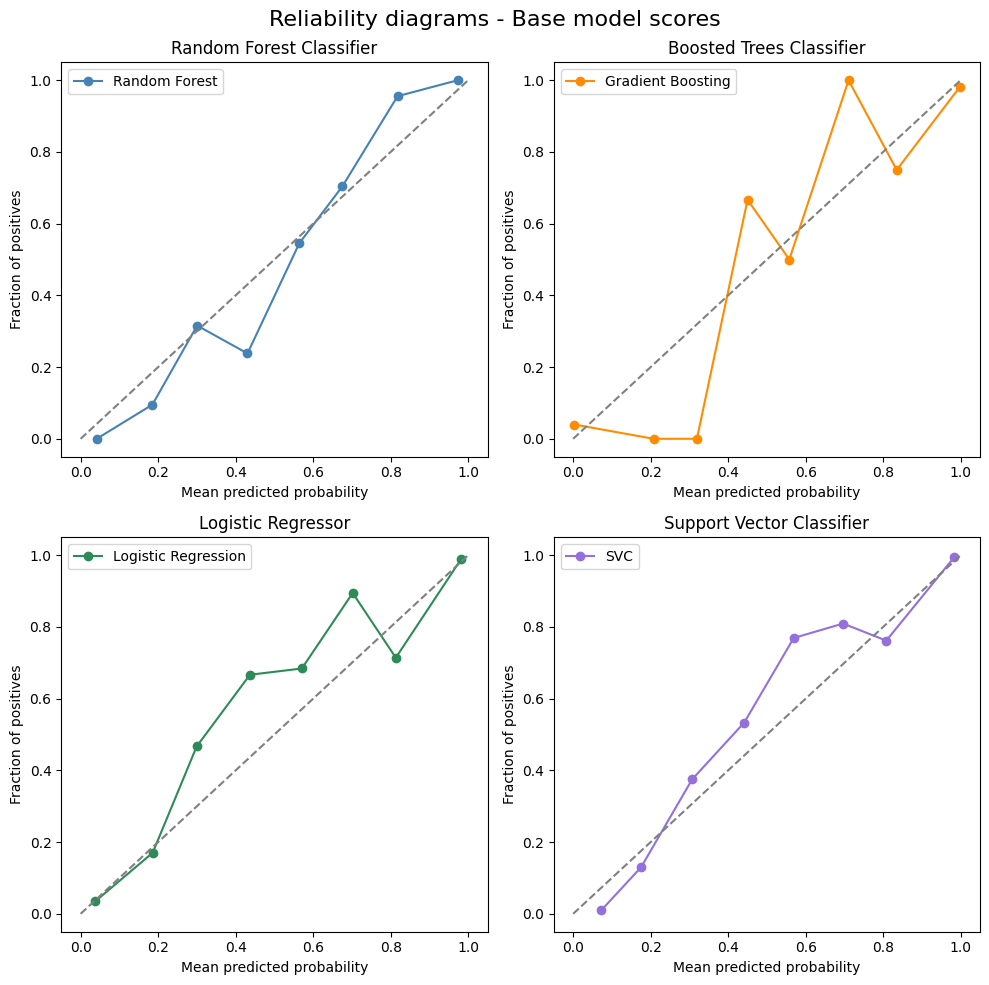

In [12]:
rf,xgb,lr,svc=load_models(os.path.join('..','Models','output'))
X_valid, y_valid=load_validation_data(os.path.join('..','Data','output','train_data_1.csv'))

# RF
model_rf=rf['modelo']
encoder_rf=rf['encoder']

X_valid_rf=preprocess_data(encoder_rf,X_valid)
X_valid_rf=X_valid_rf.drop(columns=['10d'])

# XGBoost
model_xgb=xgb['modelo']
encoder_xgb=xgb['encoder']

X_valid_xgb=preprocess_data(encoder_xgb,X_valid)
X_valid_xgb=X_valid_xgb.drop(columns=['10d'])

# Logistic Reg
model_lr=lr['modelo']
encoder_lr=lr['encoder']

X_valid_lr=preprocess_data(encoder_lr,X_valid)
X_valid_lr=X_valid_lr.drop(columns=['7d','15d','60d'])

# SVC
model_svc=svc['modelo']
encoder_svc=svc['encoder']

X_valid_svc=preprocess_data(encoder_svc,X_valid)
X_valid_svc=X_valid_svc.drop(columns=['10d'])

# Obtener las probabilidades predichas
y_pred_rf = model_rf.predict_proba(X_valid_rf)[:, 1]
y_pred_xgb = model_xgb.predict_proba(X_valid_xgb)[:, 1] 
y_pred_lr = model_lr.predict_proba(X_valid_lr)[:, 1]
y_pred_svc = model_svc.predict_proba(X_valid_svc)[:, 1] 

# Obtener las curvas de calibración
fraction_of_positives_rf, mean_predicted_value_rf = calibration_curve(y_valid, y_pred_rf, n_bins=n_bins,strategy='uniform') # strategy{‘uniform’, ‘quantile’}
fraction_of_positives_xgb, mean_predicted_value_xgb = calibration_curve(y_valid, y_pred_xgb, n_bins=n_bins,strategy='uniform')
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_valid, y_pred_lr, n_bins=n_bins,strategy='uniform')
fraction_of_positives_svc, mean_predicted_value_svc = calibration_curve(y_valid, y_pred_svc, n_bins=n_bins,strategy='uniform')

# Crear una figura con 4 subgráficas
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2 filas y 2 columnas
fig.suptitle('Reliability diagrams - Base model scores', fontsize=16)
# Definir colores profesionales
colors = ['steelblue', 'darkorange', 'seagreen', 'mediumpurple']

# Graficar la curva de calibración de cada modelo en una subgráfica
axes[0, 0].plot(mean_predicted_value_rf, fraction_of_positives_rf, marker='o', color=colors[0], label='Random Forest')
axes[0, 0].plot([0, 1], [0, 1], linestyle='--', color='gray')  # Línea ideal
axes[0, 0].set_title('Random Forest Classifier', fontsize=12)
axes[0, 0].set_xlabel('Mean predicted probability')
axes[0, 0].set_ylabel('Fraction of positives')
axes[0, 0].legend(loc='best')

axes[0, 1].plot(mean_predicted_value_xgb, fraction_of_positives_xgb, marker='o', color=colors[1], label='Gradient Boosting')
axes[0, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')  # Línea ideal
axes[0, 1].set_title('Boosted Trees Classifier', fontsize=12)
axes[0, 1].set_xlabel('Mean predicted probability')
axes[0, 1].set_ylabel('Fraction of positives')
axes[0, 1].legend(loc='best')

axes[1, 0].plot(mean_predicted_value_lr, fraction_of_positives_lr, marker='o', color=colors[2], label='Logistic Regression')
axes[1, 0].plot([0, 1], [0, 1], linestyle='--', color='gray')  # Línea ideal
axes[1, 0].set_title('Logistic Regressor', fontsize=12)
axes[1, 0].set_xlabel('Mean predicted probability')
axes[1, 0].set_ylabel('Fraction of positives')
axes[1, 0].legend(loc='best')

axes[1, 1].plot(mean_predicted_value_svc, fraction_of_positives_svc, marker='o', color=colors[3], label='SVC')
axes[1, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')  # Línea ideal
axes[1, 1].set_title('Support Vector Classifier', fontsize=12)
axes[1, 1].set_xlabel('Mean predicted probability')
axes[1, 1].set_ylabel('Fraction of positives')
axes[1, 1].legend(loc='best')

# Ajustar el espacio entre subgráficas
plt.tight_layout()
plt.savefig('../Reports/curvas_calibracion_base.png', dpi=300, bbox_inches='tight')  # Guardar la imagen

# Mostrar la figura
plt.show()

En la siguiente gráfica de ejemplo, podemos ver el eje X (Mean predicted value) representa las probabilidades predichas por cada uno de los modelos, va de 0 a 1, indicando la confianza con la que los modelos estiman la existencia de deslizamientos de tierra (clase positiva). Respecto al eje Y (Fraction of positives) muestra la fracción de positivos reales, es decir, la proporción de veces que un evento predicho como probable en realidad ocurre en el conjunto de datos.
Todas las series serán comparadas con una línea que representa el caso de calibración perfecta. Si un modelo está perfectamente calibrado, los puntos de su curva se alinearán con esta diagonal, indicando que las probabilidades predichas coinciden con las frecuencias observadas de los deslizamientos de tierra reales. Por ejemplo, una predicción de deslizamiento de tierra de 0.6 significaría que en el 60% de los casos ese evento ocurre realmente.


Dicho esto, y al ver la gráfica, el `Logistic Regressor` parece ser el mejor calibrado para estimar probabilidades, seguido por el `Support Vector Classifer`, que son los que más se ajustan a la línea diagonal 'ideal'. El `Gradient Boosting Classifier` también se comporta razonablemente bien, mientras que el `Random Forest Classifier` es el que menos confiable es en cuanto a la calibración de probabilidades.

Veamos su distribución

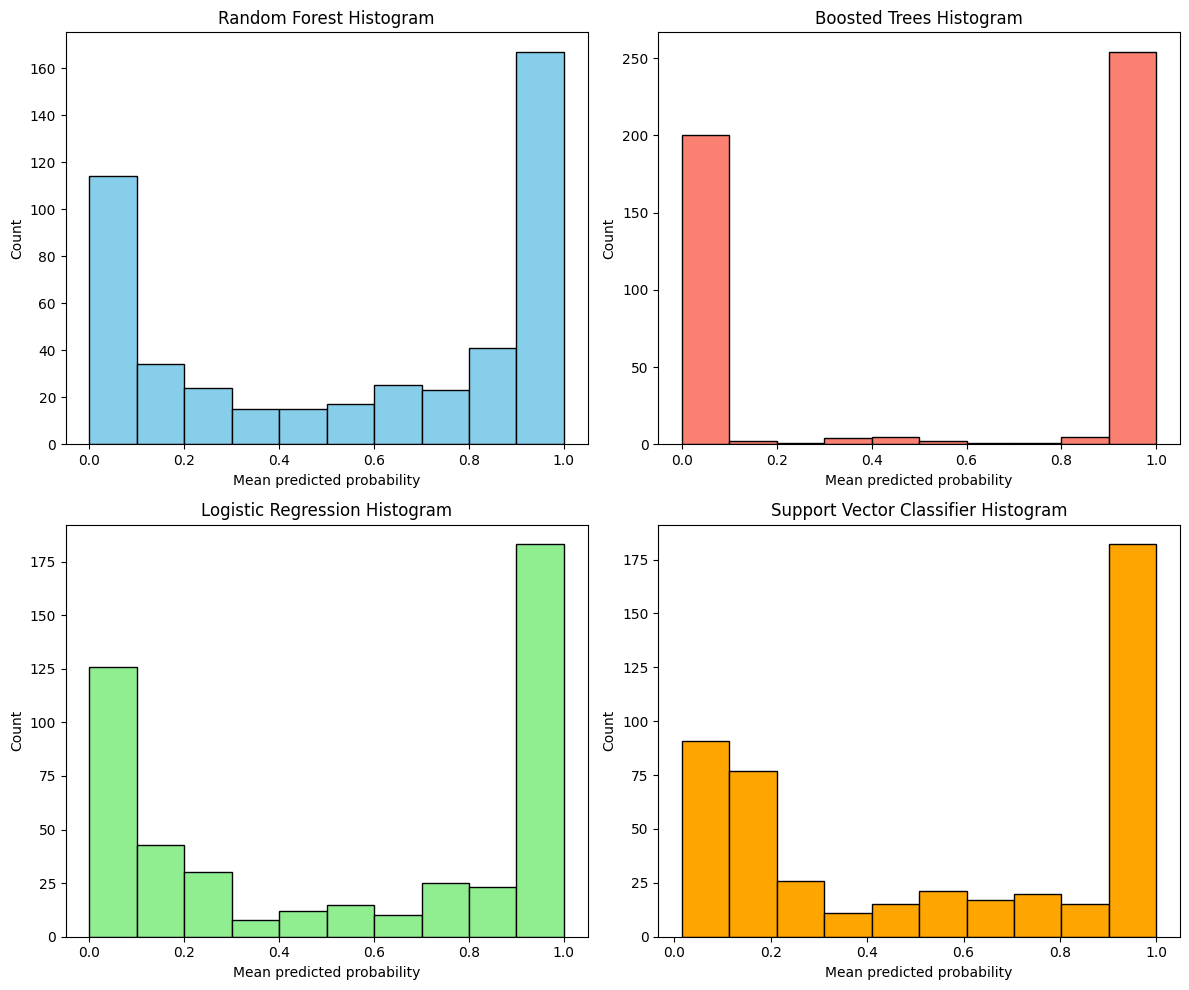

In [13]:
# Suponiendo que tienes un DataFrame llamado `df` con las cuatro columnas de interés
dict_hist = {"Random Forest":y_pred_rf, "Boosted Trees":y_pred_xgb, "Logistic Regression":y_pred_lr,
              "Support Vector Classifier":y_pred_svc}
colores = ['skyblue', 'salmon', 'lightgreen', 'orange']  # Lista de colores para cada histograma

# Configura el tamaño del plot y la cuadrícula 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Itera sobre cada columna y cada subplot
for j,(i, col) in enumerate(dict_hist.items()):
    ax = axs[j // 2, j % 2]  # Selección de subplot en la cuadrícula
    ax.hist(col, bins=10,color=colores[j], edgecolor='black')
    ax.set_title(f'{i} Histogram')
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('Count')

# Ajusta el espaciado entre subplots
plt.tight_layout()
plt.savefig('../Reports/histograms_base.png', dpi=300, bbox_inches='tight')  # Guardar la imagen
plt.show()

Ahora, calculemos los indicadores expuestos y explicados en la sección de [Calibradores de probabilidad](intro.md#calibradores-de-probabilidad)

In [14]:
# Calcular log loss y Brier score
logloss_rf = log_loss(y_valid, y_pred_rf)
brier_rf = brier_score_loss(y_valid, y_pred_rf)

logloss_xgb = log_loss(y_valid, y_pred_xgb)
brier_xgb = brier_score_loss(y_valid, y_pred_xgb)

logloss_lr = log_loss(y_valid, y_pred_lr)
brier_lr = brier_score_loss(y_valid, y_pred_lr)

logloss_svc = log_loss(y_valid, y_pred_svc)
brier_svc = brier_score_loss(y_valid, y_pred_svc)

# Calcular ECE para cada caso
ece_rf = calculate_ece(y_valid, y_pred_rf,fraction_of_positives_rf,mean_predicted_value_rf)
ece_xgb = calculate_ece(y_valid, y_pred_xgb,fraction_of_positives_xgb,mean_predicted_value_xgb)
ece_lr = calculate_ece(y_valid, y_pred_lr,fraction_of_positives_lr,mean_predicted_value_lr)
ece_svc = calculate_ece(y_valid, y_pred_svc,fraction_of_positives_svc,mean_predicted_value_svc)

# Agregar resultados a la lista
indicators={'Classifier': ['Random Forest Classifier','Gradient Boosting Classifier','Logistic Regressor','Support Vector Classifer'],
            'ECE': [ece_rf,ece_xgb,ece_lr,ece_svc],
            'Brier Score': [brier_rf,brier_xgb,brier_lr,brier_svc],
            'Log Loss': [logloss_rf,logloss_xgb,logloss_lr,logloss_svc]
            }
indicators_df = pd.DataFrame(indicators)
indicators_df

,Classifier,ECE,Brier Score,Log Loss
0,Random Forest Classifier,0.053239,0.056771,0.195018
1,Gradient Boosting Classifier,0.032253,0.033180,0.155890
2,Logistic Regressor,0.036069,0.071608,0.225550
3,Support Vector Classifer,0.049949,0.071822,0.234976


- **Gradient Boosting Classifier**:
    Brier Score: El más bajo (0.038939) y el segundo mejor en Log Loss (0.150294). Esto concuerda con su comportamiento en la curva de calibración, donde se en promedio a lo largo de la líena 'ideal' se mantiene cerca en la mayoría de los puntos.

- **Random Forest Classifier:**
    Brier Score: Un poco más alto que el Gradient Boosting (0.044810), pero no se desempeña bien en la curva de calibración, mostrando una gran discrepancia con la línea diagonal. Esto indica que, aunque su Brier Score no es el peor, su capacidad para calibrar probabilidades es deficiente.

- **Logistic Regressor:**
    Brier Score: 0.074663, que es mayor que los dos anteriores, y su Log Loss es el más alto (0.240863). En la curva de calibración, mostró un rendimiento decente, pero sus métricas indican que tiene un desempeño menos confiable en comparación con los mejores modelos.

- **Support Vector Classifier:**
    Brier Score y Log Loss: Ambos son los peores entre los modelos, lo que concuerda con su comportamiento en la curva de calibración, donde se aleja significativamente de la línea diagonal.

## Aplicar Calibración

### Platt Scaling

In [15]:
# Calibrar el modelo lr
calibrated_mode_lr = CalibratedClassifierCV(model_lr, method='sigmoid', cv='prefit')
calibrated_mode_lr.fit(X_valid_lr, y_valid)  # Solo ajusta la calibración

# Predecir probabilidades calibradas para el modelo 1
y_prob_calibrated_lr = calibrated_mode_lr.predict_proba(X_valid_lr)[:, 1]


# ------------------------------------------------------------

# Calibrar el modelo svc
calibrated_mode_svc = CalibratedClassifierCV(model_svc, method='sigmoid', cv='prefit')
calibrated_mode_svc.fit(X_valid_svc, y_valid)  # Solo ajusta la calibración

# Predecir probabilidades calibradas para el modelo 1
y_prob_calibrated_svc = calibrated_mode_svc.predict_proba(X_valid_svc)[:, 1]




# ------------------------------------------------------------

# Calibrar el modelo xgb
calibrated_mode_xgb = CalibratedClassifierCV(model_xgb, method='sigmoid', cv='prefit')
calibrated_mode_xgb.fit(X_valid_xgb, y_valid)  # Solo ajusta la calibración

# Predecir probabilidades calibradas para el modelo 1
y_prob_calibrated_xgb = calibrated_mode_xgb.predict_proba(X_valid_xgb)[:, 1]



# ------------------------------------------------------------

# Calibrar el modelo rf
calibrated_mode_rf = CalibratedClassifierCV(model_rf, method='sigmoid', cv='prefit')
calibrated_mode_rf.fit(X_valid_rf, y_valid)  # Solo ajusta la calibración

# Predecir probabilidades calibradas para el modelo 1
y_prob_calibrated_rf = calibrated_mode_rf.predict_proba(X_valid_rf)[:, 1]




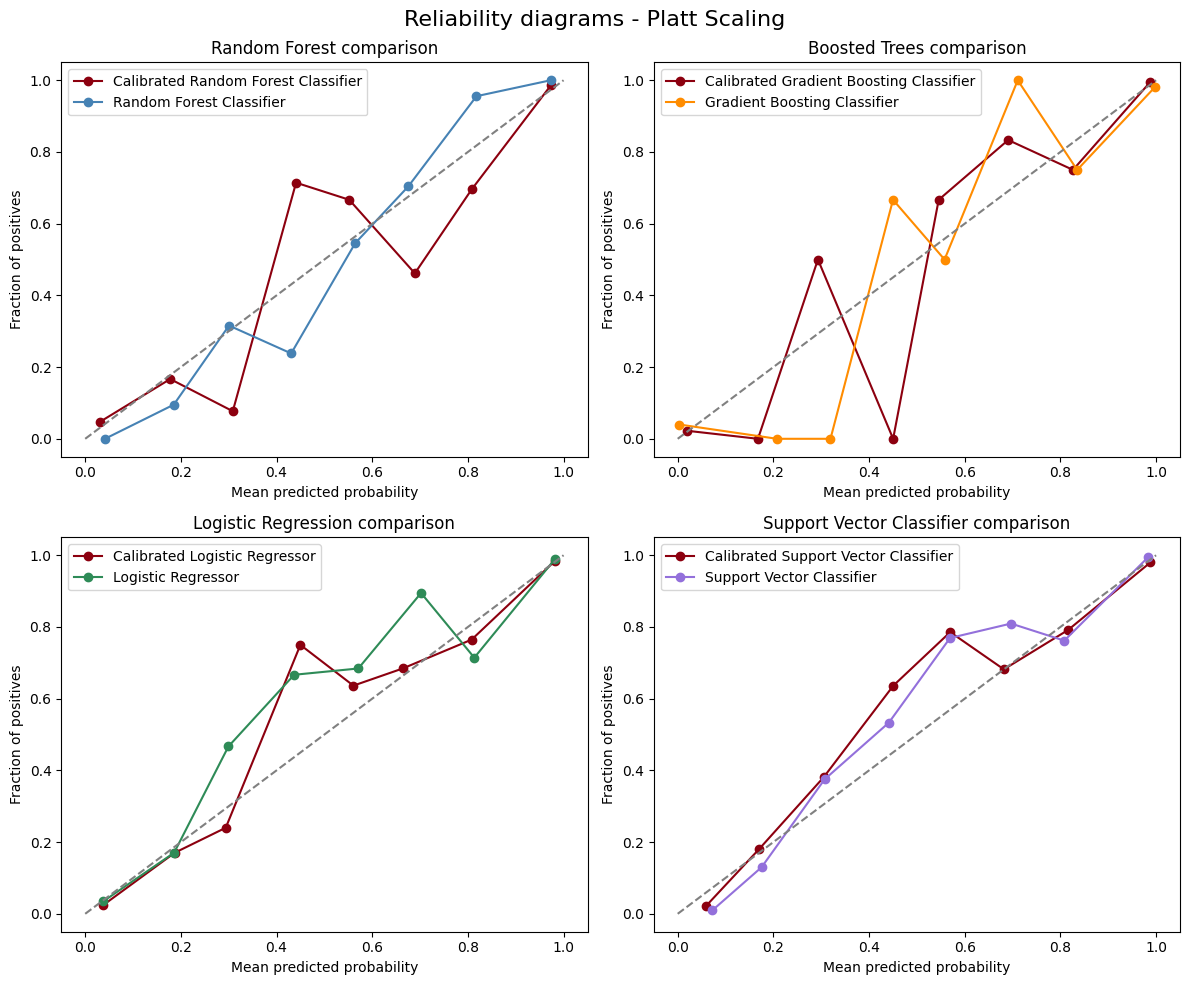

In [16]:
# Obtener las curvas de calibración para cada modelo
fraction_of_positives_rf_calibrated, mean_predicted_value_rf_calibrated = calibration_curve(y_valid, y_prob_calibrated_rf, n_bins=n_bins, strategy='uniform')
fraction_of_positives_xgb_calibrated, mean_predicted_value_xgb_calibrated = calibration_curve(y_valid, y_prob_calibrated_xgb, n_bins=n_bins, strategy='uniform')
fraction_of_positives_lr_calibrated, mean_predicted_value_lr_calibrated = calibration_curve(y_valid, y_prob_calibrated_lr, n_bins=n_bins, strategy='uniform')
fraction_of_positives_svc_calibrated, mean_predicted_value_svc_calibrated = calibration_curve(y_valid, y_prob_calibrated_svc, n_bins=n_bins, strategy='uniform')

# Crear una figura con cuatro subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Reliability diagrams - Platt Scaling', fontsize=16)
colors = ['steelblue', 'darkorange', 'seagreen', 'mediumpurple']

# Configurar el gráfico para el Random Forest
axs[0, 0].plot(mean_predicted_value_rf_calibrated, fraction_of_positives_rf_calibrated, marker='o', color='#8C000F', label='Calibrated Random Forest Classifier')
axs[0, 0].plot(mean_predicted_value_rf, fraction_of_positives_rf, marker='o', color=colors[0], label='Random Forest Classifier')
axs[0, 0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[0, 0].set_title('Random Forest comparison')
axs[0, 0].set_xlabel('Mean predicted probability')
axs[0, 0].set_ylabel('Fraction of positives')
axs[0, 0].legend() 

# Configurar el gráfico para el Gradient Boosting
axs[0, 1].plot(mean_predicted_value_xgb_calibrated, fraction_of_positives_xgb_calibrated, marker='o', color='#8C000F', label='Calibrated Gradient Boosting Classifier')
axs[0, 1].plot(mean_predicted_value_xgb, fraction_of_positives_xgb, marker='o', color=colors[1], label='Gradient Boosting Classifier')
axs[0, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[0, 1].set_title('Boosted Trees comparison')
axs[0, 1].set_xlabel('Mean predicted probability')
axs[0, 1].set_ylabel('Fraction of positives')
axs[0, 1].legend() 

# Configurar el gráfico para Logistic Regression
axs[1, 0].plot(mean_predicted_value_lr_calibrated, fraction_of_positives_lr_calibrated, marker='o', color='#8C000F', label='Calibrated Logistic Regressor')
axs[1, 0].plot(mean_predicted_value_lr, fraction_of_positives_lr, marker='o', color=colors[2], label='Logistic Regressor')
axs[1, 0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[1, 0].set_title('Logistic Regression comparison')
axs[1, 0].set_xlabel('Mean predicted probability')
axs[1, 0].set_ylabel('Fraction of positives')
axs[1, 0].legend() 

# Configurar el gráfico para Support Vector Classifier
axs[1, 1].plot(mean_predicted_value_svc_calibrated, fraction_of_positives_svc_calibrated, marker='o', color='#8C000F', label='Calibrated Support Vector Classifier')
axs[1, 1].plot(mean_predicted_value_svc, fraction_of_positives_svc, marker='o', color=colors[3], label='Support Vector Classifier')
axs[1, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[1, 1].set_title('Support Vector Classifier comparison')
axs[1, 1].set_xlabel('Mean predicted probability')
axs[1, 1].set_ylabel('Fraction of positives')
axs[1, 1].legend() 

# Ajustar el espacio entre gráficos
plt.tight_layout()

plt.savefig('../Reports/curvas_calibracion_plattscaling.png', dpi=300, bbox_inches='tight')  # Guardar la imagen

# Mostrar la figura con todos los subgráficos
plt.show()
#

In [17]:


# Evaluar la calibración del modelo 1 usando el Brier score
logloss_lr_c = log_loss(y_valid, y_prob_calibrated_lr)
brier_lr_c = brier_score_loss(y_valid, y_prob_calibrated_lr)


# ------------------------------------------------------------


# Evaluar la calibración del modelo 1 usando el Brier score
logloss_svc_c = log_loss(y_valid, y_prob_calibrated_svc)
brier_svc_c = brier_score_loss(y_valid, y_prob_calibrated_svc)


# ------------------------------------------------------------



# Evaluar la calibración del modelo 1 usando el Brier score
logloss_xgb_c = log_loss(y_valid, y_prob_calibrated_xgb)
brier_xgb_c = brier_score_loss(y_valid, y_prob_calibrated_xgb)


# ------------------------------------------------------------


# Evaluar la calibración del modelo 1 usando el Brier score
logloss_rf_c = log_loss(y_valid, y_prob_calibrated_rf)
brier_rf_c = brier_score_loss(y_valid, y_prob_calibrated_rf)


# Calcular ECE para cada caso
ece_rf_c = calculate_ece(y_valid, y_prob_calibrated_rf,fraction_of_positives_rf_calibrated,mean_predicted_value_rf_calibrated)
ece_xgb_c = calculate_ece(y_valid, y_prob_calibrated_xgb,fraction_of_positives_xgb_calibrated,mean_predicted_value_xgb_calibrated)
ece_lr_c = calculate_ece(y_valid, y_prob_calibrated_lr,fraction_of_positives_lr_calibrated,mean_predicted_value_lr_calibrated)
ece_svc_c = calculate_ece(y_valid, y_prob_calibrated_svc,fraction_of_positives_svc_calibrated,mean_predicted_value_svc_calibrated)

indicators_pc={'Classifier': ['Sigmoid Calibrated Random Forest Classifier','Sigmoid Calibrated Gradient Boosting Classifier','Sigmoid Calibrated Logistic Regressor','Sigmoid Calibrated Support Vector Classifer'],
            'ECE': [ece_rf_c,ece_xgb_c,ece_lr_c,ece_svc_c],
            'Brier Score': [brier_rf_c,brier_xgb_c,brier_lr_c,brier_svc_c],
            'Log Loss': [logloss_rf_c,logloss_xgb_c,logloss_lr_c,logloss_svc_c]}
indicators_df_pc = pd.DataFrame(indicators_pc)
indicators_df_pc

,Classifier,ECE,Brier Score,Log Loss
0,Sigmoid Calibrated Random Forest Classifier,0.036564,0.054173,0.178029
1,Sigmoid Calibrated Gradient Boosting Classifier,0.024520,0.030608,0.106156
2,Sigmoid Calibrated Logistic Regressor,0.022398,0.070023,0.222612
3,Sigmoid Calibrated Support Vector Classifer,0.030165,0.069655,0.224920


In [18]:
# calibrated_mode_lr.calibrated_classifiers_[0]
# print(dir(calibrated_mode_lr.calibrated_classifiers_[0].calibrators[0]))


In [19]:
# calibrated_mode_lr.calibrated_classifiers_[0].calibrators[0].b_

In [20]:
# # Acceder a los parámetros de la función sigmoidal entrenada
# sigmoid_intercept = calibrated_mode_rf.calibrated_classifiers_[0].calibrators[0].b_
# sigmoid_slope = calibrated_mode_rf.calibrated_classifiers_[0].calibrators[0].a_

# # Graficar la función sigmoidal entrenada
# x_vals = np.linspace(0, 1, 1000)
# y_vals = 1 / (1 + np.exp(-(sigmoid_slope * x_vals + sigmoid_intercept)))
# plt.plot(x_vals, y_vals, label='Función Sigmoidal Entrenada', color='red', linestyle='-')

# plt.title('Curva de Calibración del Modelo')
# plt.legend()
# plt.show()

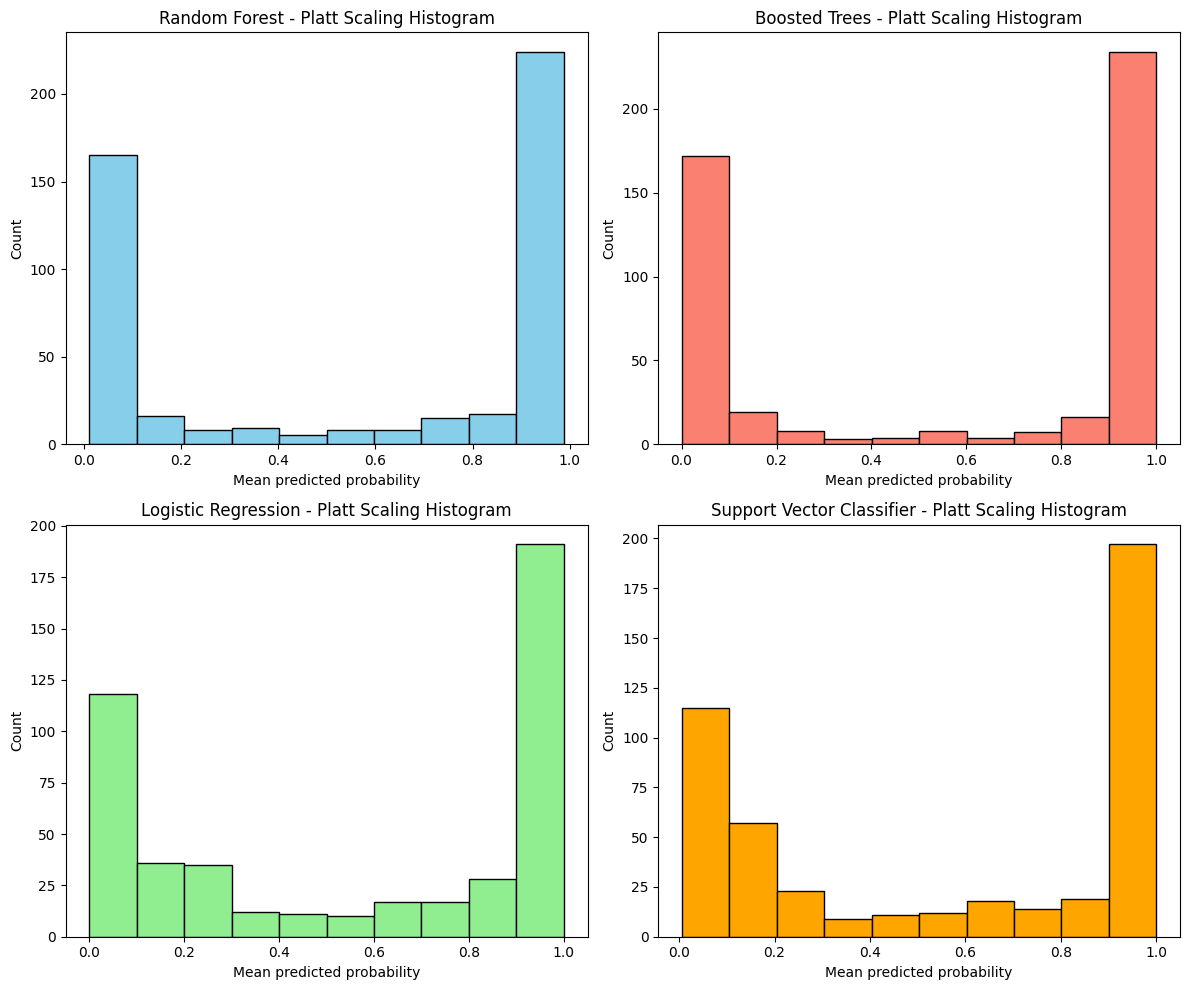

In [21]:
# Suponiendo que tienes un DataFrame llamado `df` con las cuatro columnas de interés
dict_hist = {"Random Forest - Platt Scaling":y_prob_calibrated_rf, 
             "Boosted Trees - Platt Scaling":y_prob_calibrated_xgb, 
             "Logistic Regression - Platt Scaling":y_prob_calibrated_lr,
              "Support Vector Classifier - Platt Scaling":y_prob_calibrated_svc}
colores = ['skyblue', 'salmon', 'lightgreen', 'orange']  # Lista de colores para cada histograma

# Configura el tamaño del plot y la cuadrícula 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Itera sobre cada columna y cada subplot
for j,(i, col) in enumerate(dict_hist.items()):
    ax = axs[j // 2, j % 2]  # Selección de subplot en la cuadrícula
    ax.hist(col, bins=10,color=colores[j], edgecolor='black')
    ax.set_title(f'{i} Histogram')
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('Count')

# Ajusta el espaciado entre subplots
plt.tight_layout()
plt.savefig('../Reports/histograms_plattscaling.png', dpi=300, bbox_inches='tight')  # Guardar la imagen

plt.show()

### Beta Calibration

In [22]:
# Calibrar el modelo lr
beta_calibrator_lr = BetaCalibration(parameters='abm')
beta_calibrator_lr.fit(y_pred_lr, y_valid)  # Solo ajusta la calibración

# Predecir probabilidades calibradas para el modelo 1
y_prob_calibrated_beta_lr = beta_calibrator_lr.predict(y_pred_lr)




# ------------------------------------------------------------

# Calibrar el modelo svc
beta_calibrator_svc = BetaCalibration(parameters='abm')
beta_calibrator_svc.fit(y_pred_svc, y_valid)  # Solo ajusta la calibración

# Predecir probabilidades calibradas para el modelo 1
y_prob_calibrated_beta_svc = beta_calibrator_svc.predict(y_pred_svc)



# ------------------------------------------------------------

# Calibrar el modelo xgb
beta_calibrator_xgb = BetaCalibration(parameters='abm')
beta_calibrator_xgb.fit(y_pred_xgb, y_valid)  # Solo ajusta la calibración

# Predecir probabilidades calibradas para el modelo 1
y_prob_calibrated_beta_xgb = beta_calibrator_xgb.predict(y_pred_xgb)



# ------------------------------------------------------------

# Calibrar el modelo rf
beta_calibrator_rf = BetaCalibration(parameters='abm')
beta_calibrator_rf.fit(y_pred_rf, y_valid)  # Solo ajusta la calibración

# Predecir probabilidades calibradas para el modelo 1
y_prob_calibrated_beta_rf = beta_calibrator_rf.predict(y_pred_rf)


In [23]:
# print(dir(beta_calibrator_rf.calibrator_))
# beta_calibrator_rf.calibrator_.map_

In [24]:
# from scipy.stats import beta

# # Graficar la curva de calibración para el modelo sin calibrar y calibrado
# fig, ax = plt.subplots(figsize=(10, 6))

# # Acceder a los parámetros alfa y beta de la calibración beta
# alpha, beta_param,m_value = beta_calibrator_lr.calibrator_.map_[0], beta_calibrator_lr.calibrator_.map_[1], beta_calibrator_lr.calibrator_.map_[2]

# # Graficar la función de densidad de la distribución beta
# # x_vals = np.linspace(0, 1, 1000)
# x_vals =y_pred_lr
# y_vals = beta.pdf(x_vals, alpha, beta_param)
# plt.plot(x_vals, y_vals, label=f'Distribución Beta ($\\alpha={alpha:.2f}$, $\\beta={beta_param:.2f}$)', color='red', linestyle='-')

# plt.title('Curva de Calibración del Modelo y Distribución Beta Calibrada')
# plt.legend()
# plt.show()

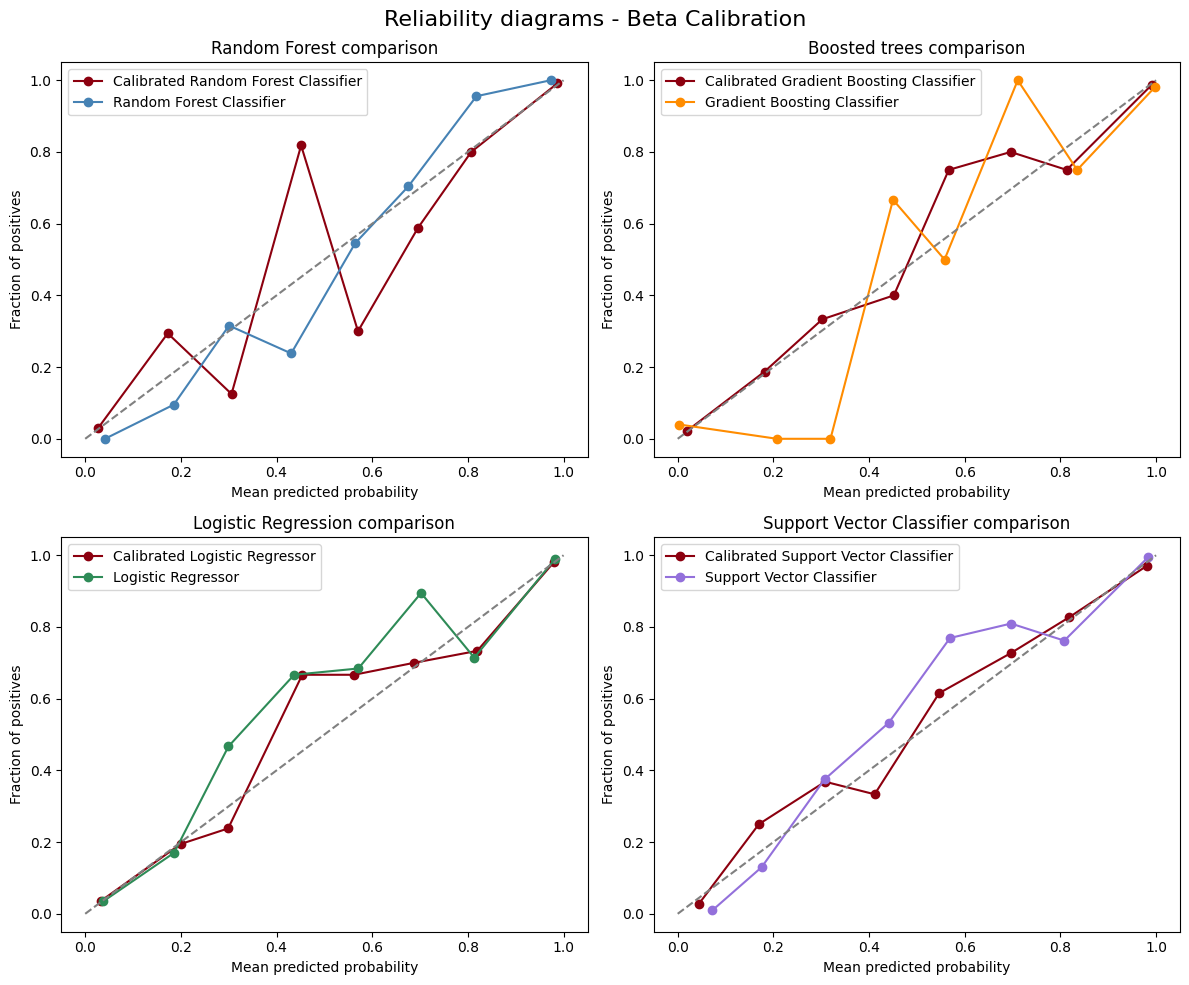

In [37]:
# Obtener las curvas de calibración para cada modelo
fraction_of_positives_rf_calibrated_beta, mean_predicted_value_rf_calibrated_beta = calibration_curve(y_valid, y_prob_calibrated_beta_rf, n_bins=n_bins, strategy='uniform')
fraction_of_positives_xgb_calibrated_beta, mean_predicted_value_xgb_calibrated_beta = calibration_curve(y_valid, y_prob_calibrated_beta_xgb, n_bins=n_bins, strategy='uniform')
fraction_of_positives_lr_calibrated_beta, mean_predicted_value_lr_calibrated_beta = calibration_curve(y_valid, y_prob_calibrated_beta_lr, n_bins=n_bins, strategy='uniform')
fraction_of_positives_svc_calibrated_beta, mean_predicted_value_svc_calibrated_beta = calibration_curve(y_valid, y_prob_calibrated_beta_svc, n_bins=n_bins, strategy='uniform')

# Crear una figura con cuatro subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Reliability diagrams - Beta Calibration', fontsize=16)
colors = ['steelblue', 'darkorange', 'seagreen', 'mediumpurple']

# Configurar el gráfico para el Random Forest
axs[0, 0].plot(mean_predicted_value_rf_calibrated_beta, fraction_of_positives_rf_calibrated_beta, marker='o',color='#8C000F', label='Calibrated Random Forest Classifier')
axs[0, 0].plot(mean_predicted_value_rf, fraction_of_positives_rf, marker='o', color=colors[0], label='Random Forest Classifier')
axs[0, 0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[0, 0].set_title('Random Forest comparison')
axs[0, 0].set_xlabel('Mean predicted probability')
axs[0, 0].set_ylabel('Fraction of positives')
axs[0, 0].legend() 

# Configurar el gráfico para el Gradient Boosting
axs[0, 1].plot(mean_predicted_value_xgb_calibrated_beta, fraction_of_positives_xgb_calibrated_beta, marker='o',color='#8C000F', label='Calibrated Gradient Boosting Classifier')
axs[0, 1].plot(mean_predicted_value_xgb, fraction_of_positives_xgb, marker='o', color=colors[1], label='Gradient Boosting Classifier')
axs[0, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[0, 1].set_title('Boosted trees comparison')
axs[0, 1].set_xlabel('Mean predicted probability')
axs[0, 1].set_ylabel('Fraction of positives')
axs[0, 1].legend() 

# Configurar el gráfico para Logistic Regression
axs[1, 0].plot(mean_predicted_value_lr_calibrated_beta, fraction_of_positives_lr_calibrated_beta, marker='o',color='#8C000F', label='Calibrated Logistic Regressor')
axs[1, 0].plot(mean_predicted_value_lr, fraction_of_positives_lr, marker='o', color=colors[2], label='Logistic Regressor')
axs[1, 0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[1, 0].set_title('Logistic Regression comparison')
axs[1, 0].set_xlabel('Mean predicted probability')
axs[1, 0].set_ylabel('Fraction of positives')
axs[1, 0].legend() 

# Configurar el gráfico para Support Vector Classifier
axs[1, 1].plot(mean_predicted_value_svc_calibrated_beta, fraction_of_positives_svc_calibrated_beta, marker='o',color='#8C000F', label='Calibrated Support Vector Classifier')
axs[1, 1].plot(mean_predicted_value_svc, fraction_of_positives_svc, marker='o', color=colors[3], label='Support Vector Classifier')
axs[1, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[1, 1].set_title('Support Vector Classifier comparison')
axs[1, 1].set_xlabel('Mean predicted probability')
axs[1, 1].set_ylabel('Fraction of positives')
axs[1, 1].legend() 

# Ajustar el espacio entre gráficos
plt.tight_layout()
plt.savefig('../Reports/curvas_calibracion_betacal.png', dpi=300, bbox_inches='tight')  # Guardar la imagen


# Mostrar la figura con todos los subgráficos
plt.show()

In [26]:


# Evaluar la calibración del modelo 1 usando el Brier score
logloss_lr_c_beta = log_loss(y_valid, y_prob_calibrated_beta_lr)
brier_lr_c_beta = brier_score_loss(y_valid, y_prob_calibrated_beta_lr)


# ------------------------------------------------------------

# Evaluar la calibración del modelo 1 usando el Brier score
logloss_svc_c_beta = log_loss(y_valid, y_prob_calibrated_beta_svc)
brier_svc_c_beta = brier_score_loss(y_valid, y_prob_calibrated_beta_svc)


# ------------------------------------------------------------


# Evaluar la calibración del modelo 1 usando el Brier score
logloss_xgb_c_beta = log_loss(y_valid, y_prob_calibrated_beta_xgb)
brier_xgb_c_beta = brier_score_loss(y_valid, y_prob_calibrated_beta_xgb)

# ------------------------------------------------------------


# Evaluar la calibración del modelo 1 usando el Brier score
logloss_rf_c_beta = log_loss(y_valid, y_prob_calibrated_beta_rf)
brier_rf_c_beta = brier_score_loss(y_valid, y_prob_calibrated_beta_rf)

# Calcular ECE para cada caso
ece_rf_c_beta = calculate_ece(y_valid, y_prob_calibrated_beta_rf,fraction_of_positives_rf_calibrated_beta, mean_predicted_value_rf_calibrated_beta)
ece_xgb_c_beta = calculate_ece(y_valid, y_prob_calibrated_beta_xgb,fraction_of_positives_xgb_calibrated_beta, mean_predicted_value_xgb_calibrated_beta)
ece_lr_c_beta = calculate_ece(y_valid, y_prob_calibrated_beta_lr,fraction_of_positives_lr_calibrated_beta, mean_predicted_value_lr_calibrated_beta)
ece_svc_c_beta = calculate_ece(y_valid, y_prob_calibrated_beta_svc,fraction_of_positives_svc_calibrated_beta, mean_predicted_value_svc_calibrated_beta)

indicators_beta={'Classifier': ['Beta Calibrated Random Forest Classifier','Beta Calibrated Gradient Boosting Classifier','Beta Calibrated Logistic Regressor','Beta Calibrated Support Vector Classifer'],
            'ECE': [ece_rf_c_beta,ece_xgb_c_beta,ece_lr_c_beta,ece_svc_c_beta],
            'Brier Score': [brier_rf_c_beta,brier_xgb_c_beta,brier_lr_c_beta,brier_svc_c_beta],
            'Log Loss': [logloss_rf_c_beta,logloss_xgb_c_beta,logloss_lr_c_beta,logloss_svc_c_beta]}
indicators_df_beta = pd.DataFrame(indicators_beta)
indicators_df_beta

,Classifier,ECE,Brier Score,Log Loss
0,Beta Calibrated Random Forest Classifier,0.031713,0.052830,0.166308
1,Beta Calibrated Gradient Boosting Classifier,0.008022,0.030675,0.104300
2,Beta Calibrated Logistic Regressor,0.016968,0.069486,0.221017
3,Beta Calibrated Support Vector Classifer,0.021882,0.067874,0.219572


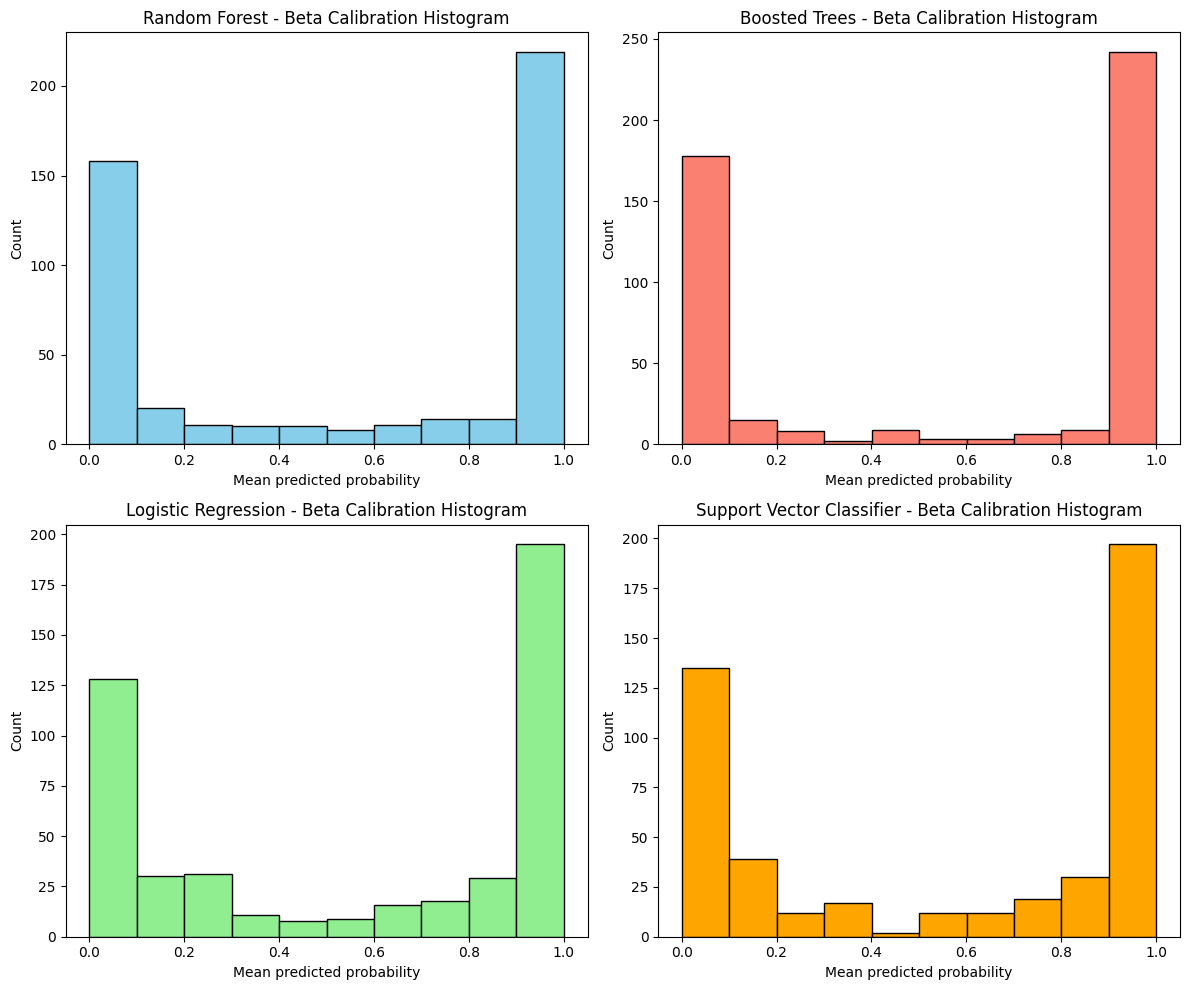

In [27]:
# Suponiendo que tienes un DataFrame llamado `df` con las cuatro columnas de interés
dict_hist = {"Random Forest - Beta Calibration":y_prob_calibrated_beta_rf, 
             "Boosted Trees - Beta Calibration":y_prob_calibrated_beta_xgb, 
             "Logistic Regression - Beta Calibration":y_prob_calibrated_beta_lr,
              "Support Vector Classifier - Beta Calibration":y_prob_calibrated_beta_svc}
colores = ['skyblue', 'salmon', 'lightgreen', 'orange']  # Lista de colores para cada histograma

# Configura el tamaño del plot y la cuadrícula 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Itera sobre cada columna y cada subplot
for j,(i, col) in enumerate(dict_hist.items()):
    ax = axs[j // 2, j % 2]  # Selección de subplot en la cuadrícula
    ax.hist(col, bins=10,color=colores[j], edgecolor='black')
    ax.set_title(f'{i} Histogram')
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('Count')

# Ajusta el espaciado entre subplots
plt.tight_layout()
plt.savefig('../Reports/histogram_betacal.png', dpi=300, bbox_inches='tight')  # Guardar la imagen

plt.show()

## Comparando Métodos

### Indicadores

In [28]:
indicators_df['Method']='Base Model'
indicators_df['Classifier']=indicators_df['Classifier'].map(
    {
    'Random Forest Classifier': 'Random Forest',
    'Gradient Boosting Classifier': 'Boosted Trees',
    'Logistic Regressor': 'Logistic Regression',
    'Support Vector Classifer': 'SVC'
}
)
indicators_df_pc['Method']='Platt Scaling'
indicators_df_pc['Classifier']=indicators_df_pc['Classifier'].map(
    {
    'Sigmoid Calibrated Random Forest Classifier': 'Random Forest',
    'Sigmoid Calibrated Gradient Boosting Classifier': 'Boosted Trees',
    'Sigmoid Calibrated Logistic Regressor': 'Logistic Regression',
    'Sigmoid Calibrated Support Vector Classifer': 'SVC'
}
)
indicators_df_beta['Method']='Beta Calibration'
indicators_df_beta['Classifier']=indicators_df_beta['Classifier'].map(
    {
    'Beta Calibrated Random Forest Classifier': 'Random Forest',
    'Beta Calibrated Gradient Boosting Classifier': 'Boosted Trees',
    'Beta Calibrated Logistic Regressor': 'Logistic Regression',
    'Beta Calibrated Support Vector Classifer': 'SVC'
}
)
full_indicators=pd.concat([indicators_df,indicators_df_pc,indicators_df_beta],ignore_index=True)
full_indicators

,Classifier,ECE,Brier Score,Log Loss,Method
0,Random Forest,0.053239,0.056771,0.195018,Base Model
1,Boosted Trees,0.032253,0.033180,0.155890,Base Model
2,Logistic Regression,0.036069,0.071608,0.225550,Base Model
3,SVC,0.049949,0.071822,0.234976,Base Model
4,Random Forest,0.036564,0.054173,0.178029,Platt Scaling
5,Boosted Trees,0.024520,0.030608,0.106156,Platt Scaling
6,Logistic Regression,0.022398,0.070023,0.222612,Platt Scaling
7,SVC,0.030165,0.069655,0.224920,Platt Scaling
8,Random Forest,0.031713,0.052830,0.166308,Beta Calibration
9,Boosted Trees,0.008022,0.030675,0.104300,Beta Calibration


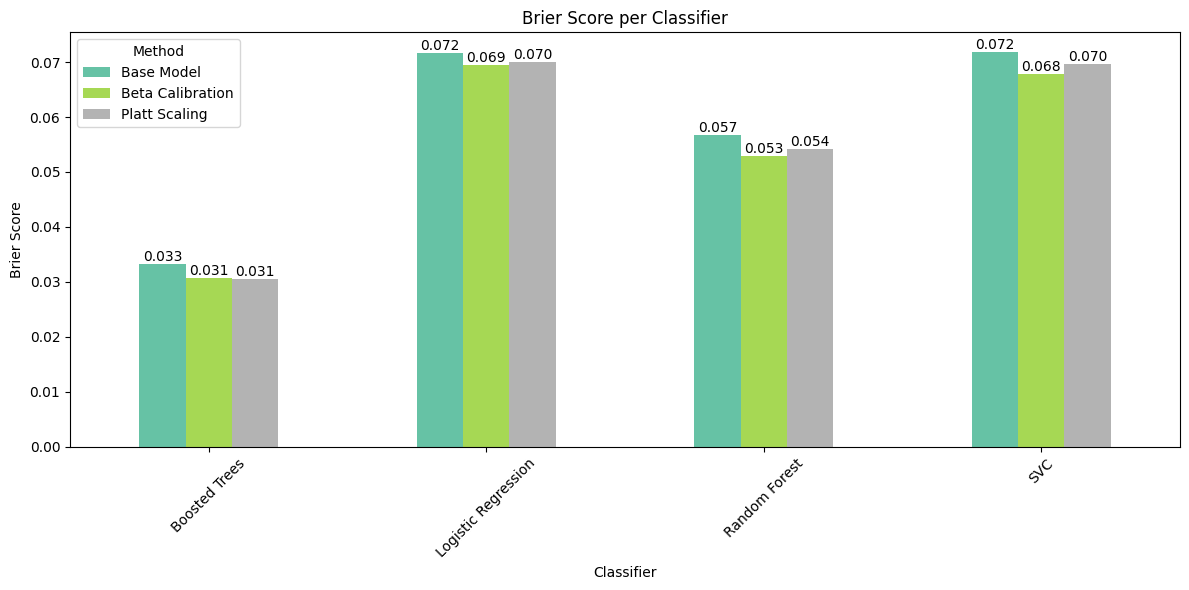

In [29]:
# Crear el gráfico de barras Brier Score
# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
df_pivot = full_indicators.pivot(index='Classifier', columns='Method', values='Brier Score')
ax = df_pivot.plot(kind='bar', ax=plt.gca(), colormap='Set2')

# Agregar etiquetas de número a cada barra
for container in ax.containers:
    # Agregar valores en la parte superior de las barras
    for bar in container:
        height = bar.get_height()
        if not pd.isna(height):  # Ignorar barras vacías
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # Posición x
                height,  # Posición y
                f'{height:.3f}',  # Texto (redondeado a 2 decimales)
                ha='center', va='bottom', fontsize=10  # Estilo del texto
            )

# Configuración del gráfico
plt.title('Brier Score per Classifier')
plt.ylabel('Brier Score')
plt.xlabel('Classifier')
plt.xticks(rotation=45)
plt.legend(title='Method')
plt.tight_layout()
plt.savefig('../Reports/bier_score_barplot.png', dpi=300, bbox_inches='tight')  # Guardar la imagen

# Mostrar el gráfico
plt.show()

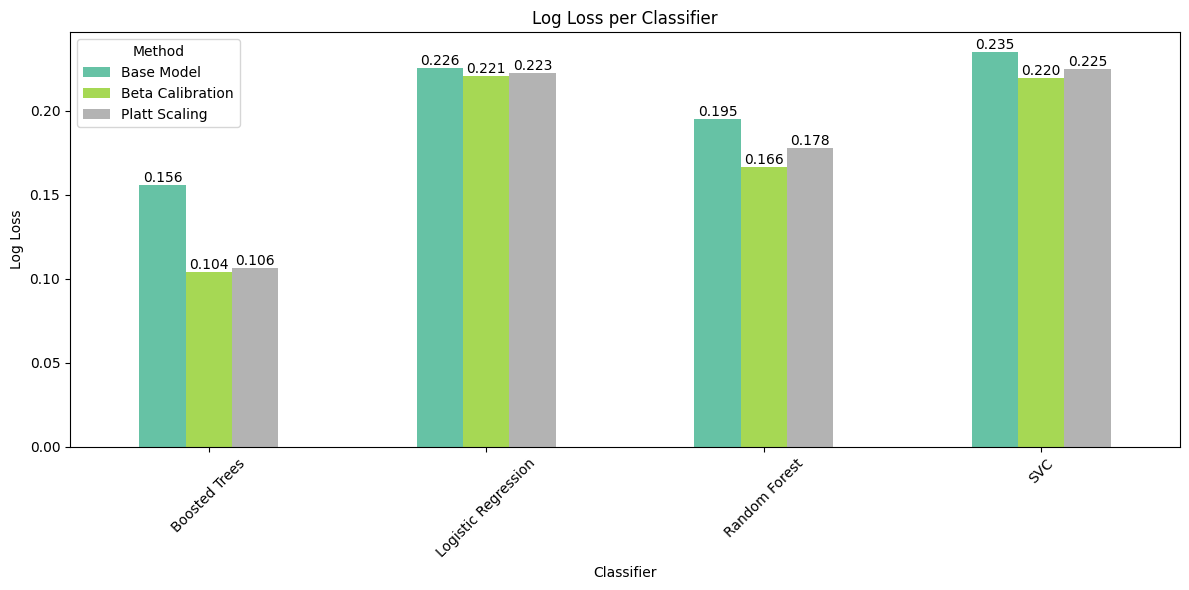

In [30]:
# Crear el gráfico de barras Log Loss
# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
df_pivot = full_indicators.pivot(index='Classifier', columns='Method', values='Log Loss')
ax = df_pivot.plot(kind='bar', ax=plt.gca(), colormap='Set2')

# Agregar etiquetas de número a cada barra
for container in ax.containers:
    # Agregar valores en la parte superior de las barras
    for bar in container:
        height = bar.get_height()
        if not pd.isna(height):  # Ignorar barras vacías
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # Posición x
                height,  # Posición y
                f'{height:.3f}',  # Texto (redondeado a 2 decimales)
                ha='center', va='bottom', fontsize=10  # Estilo del texto
            )

# Configuración del gráfico
plt.title('Log Loss per Classifier')
plt.ylabel('Log Loss')
plt.xlabel('Classifier')
plt.xticks(rotation=45)
plt.legend(title='Method')
plt.tight_layout()
plt.savefig('../Reports/logloss_barplot.png', dpi=300, bbox_inches='tight')  # Guardar la imagen

# Mostrar el gráfico
plt.show()


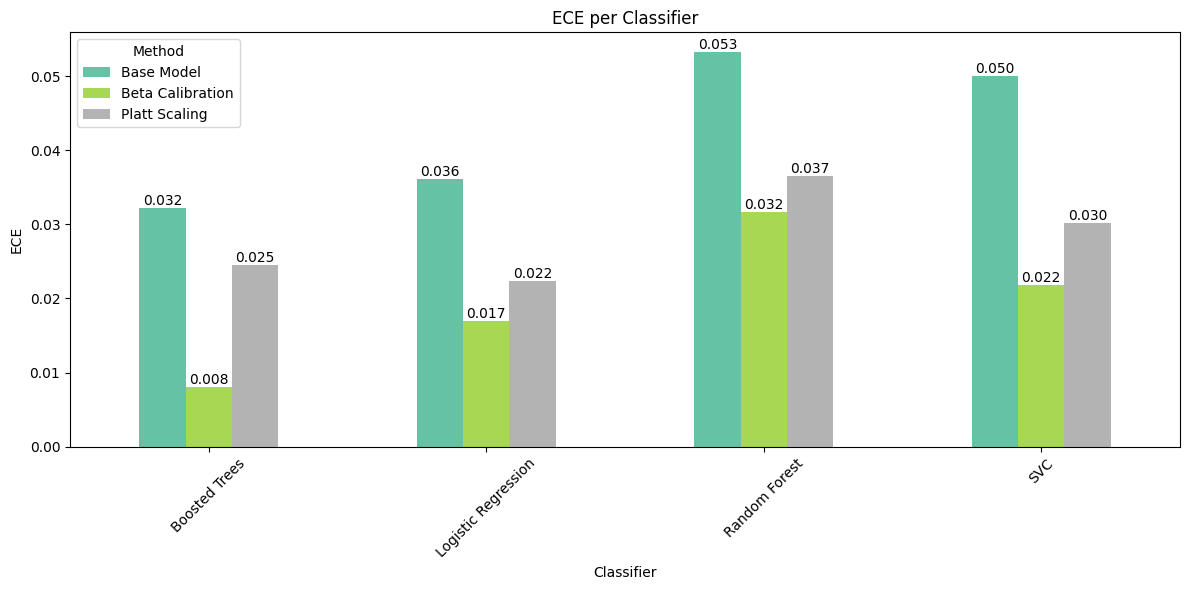

In [31]:
# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
df_pivot = full_indicators.pivot(index='Classifier', columns='Method', values='ECE')
ax = df_pivot.plot(kind='bar', ax=plt.gca(), colormap='Set2')

# Agregar etiquetas de número a cada barra
for container in ax.containers:
    # Agregar valores en la parte superior de las barras
    for bar in container:
        height = bar.get_height()
        if not pd.isna(height):  # Ignorar barras vacías
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # Posición x
                height,  # Posición y
                f'{height:.3f}',  # Texto (redondeado a 2 decimales)
                ha='center', va='bottom', fontsize=10  # Estilo del texto
            )

# Configuración del gráfico
plt.title('ECE per Classifier')
plt.ylabel('ECE')
plt.xlabel('Classifier')
plt.xticks(rotation=45)
plt.legend(title='Method')
plt.tight_layout()
plt.savefig('../Reports/ece_barplot.png', dpi=300, bbox_inches='tight')  # Guardar la imagen

# Mostrar el gráfico
plt.show()

### Diagramas de fiabilidad

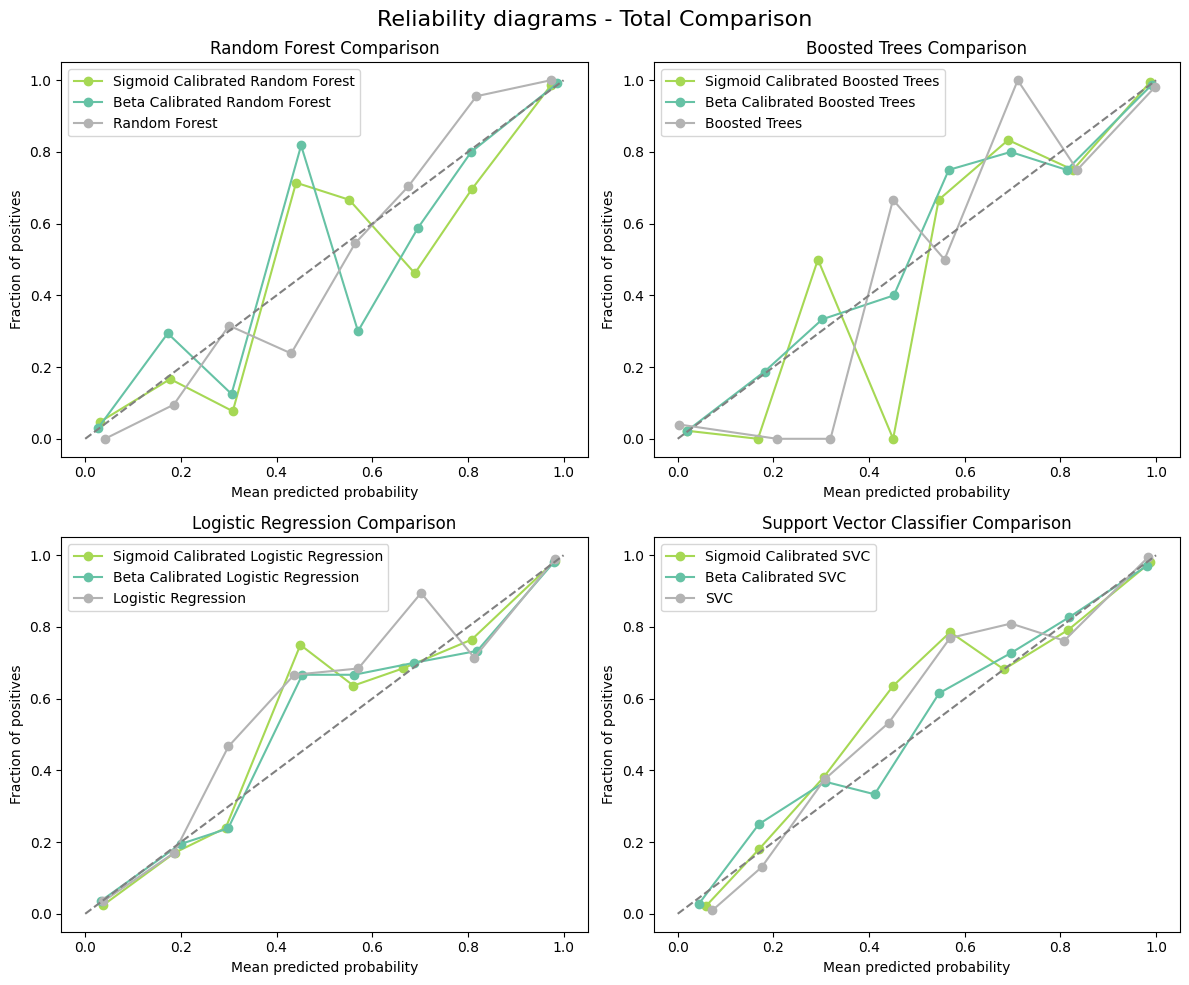

In [32]:
# Obtener colores de la paleta Set2
colors=['#a6d854','#66c2a5','#b3b3b3']
# Crear una figura con cuatro subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Reliability diagrams - Total Comparison', fontsize=16)

# Configurar el gráfico para el Random Forest
axs[0, 0].plot(mean_predicted_value_rf_calibrated, fraction_of_positives_rf_calibrated, marker='o', label='Sigmoid Calibrated Random Forest', color=colors[0])
axs[0, 0].plot(mean_predicted_value_rf_calibrated_beta, fraction_of_positives_rf_calibrated_beta, marker='o', label='Beta Calibrated Random Forest', color=colors[1])
axs[0, 0].plot(mean_predicted_value_rf, fraction_of_positives_rf, marker='o', label='Random Forest', color=colors[2])
axs[0, 0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[0, 0].set_title('Random Forest Comparison')
axs[0, 0].set_xlabel('Mean predicted probability')
axs[0, 0].set_ylabel('Fraction of positives')
axs[0, 0].legend() 

# Configurar el gráfico para el Gradient Boosting
axs[0, 1].plot(mean_predicted_value_xgb_calibrated, fraction_of_positives_xgb_calibrated, marker='o', label='Sigmoid Calibrated Boosted Trees', color=colors[0])
axs[0, 1].plot(mean_predicted_value_xgb_calibrated_beta, fraction_of_positives_xgb_calibrated_beta, marker='o', label='Beta Calibrated Boosted Trees', color=colors[1])
axs[0, 1].plot(mean_predicted_value_xgb, fraction_of_positives_xgb, marker='o', label='Boosted Trees', color=colors[2])
axs[0, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[0, 1].set_title('Boosted Trees Comparison')
axs[0, 1].set_xlabel('Mean predicted probability')
axs[0, 1].set_ylabel('Fraction of positives')
axs[0, 1].legend() 

# Configurar el gráfico para Logistic Regression 
axs[1, 0].plot(mean_predicted_value_lr_calibrated, fraction_of_positives_lr_calibrated, marker='o', label='Sigmoid Calibrated Logistic Regression', color=colors[0])
axs[1, 0].plot(mean_predicted_value_lr_calibrated_beta, fraction_of_positives_lr_calibrated_beta, marker='o', label='Beta Calibrated Logistic Regression', color=colors[1])
axs[1, 0].plot(mean_predicted_value_lr, fraction_of_positives_lr, marker='o', label='Logistic Regression', color=colors[2])
axs[1, 0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[1, 0].set_title('Logistic Regression Comparison')
axs[1, 0].set_xlabel('Mean predicted probability')
axs[1, 0].set_ylabel('Fraction of positives')
axs[1, 0].legend() 

# Configurar el gráfico para Support Vector Classifier 
axs[1, 1].plot(mean_predicted_value_svc_calibrated, fraction_of_positives_svc_calibrated, marker='o', label='Sigmoid Calibrated SVC', color=colors[0])
axs[1, 1].plot(mean_predicted_value_svc_calibrated_beta, fraction_of_positives_svc_calibrated_beta, marker='o', label='Beta Calibrated SVC', color=colors[1])
axs[1, 1].plot(mean_predicted_value_svc, fraction_of_positives_svc, marker='o', label='SVC', color=colors[2])
axs[1, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[1, 1].set_title('Support Vector Classifier Comparison')
axs[1, 1].set_xlabel('Mean predicted probability')
axs[1, 1].set_ylabel('Fraction of positives')
axs[1, 1].legend() 

# Ajustar el espacio entre gráficos
plt.tight_layout()


# Mostrar la figura con todos los subgráficos
plt.show()

Despues de comparar metricas de calibracion y modelos, se toma la decision de implementar el modelo de Boosted Trees calibrado con Beta Calibration para el uso del DSS

## Exportacion

In [33]:
def export_pickle(objeto, ruta_archivo):
    # Verificar si la ruta del directorio existe, si no, crearla
    directorio = os.path.dirname(ruta_archivo)
    if not os.path.exists(directorio):
        os.makedirs(directorio)

    # Guardar el objeto en un archivo pickle en la ruta especificada
    with open(ruta_archivo, 'wb') as archivo:
        pickle.dump(objeto, archivo)
    print(f'Objeto exportado exitosamente a {ruta_archivo}')



In [38]:
production_model= {
    "model": model_svc,
    "calibrator": beta_calibrator_svc
    }

In [39]:
nombre_modelo='production-model'
ruta_m=os.path.join('..','Models','output',f'{nombre_modelo}.pkl')
export_pickle(production_model,ruta_m)

Objeto exportado exitosamente a ..\Models\output\production-model.pkl
